In [1]:
from os.path import join as opj
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [2]:
data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path)
rna = data['rna_train']
atac = data['atac_train_small']

In [19]:
def zero_frac(arr):
    zero_count = np.count_nonzero(arr==0)
    return zero_count/arr.size

print('rna zero frac:', zero_frac(rna))
print('atac zero frac:', zero_frac(atac))

rna zero frac: 0.0
atac zero frac: 0.9740022531413609


In [63]:
from sklearn.decomposition import PCA

def test_pca_reconstruction(arr, n_components):
    baseline = np.var(arr)*arr.size # mse for mean prediction
    pca = PCA(n_components=n_components)
    pca.fit(arr)
    trans = pca.transform(arr)
    recon = pca.inverse_transform(trans)
    mse = ((arr - recon)*(arr - recon)).sum()
    return mse/baseline

In [69]:
mses = []
n_vals = [10*(2**k) for k in range(9)]
for n_components in n_vals:
    mses.append(test_pca_reconstruction(atac, n_components))

In [70]:
import pandas as pd
pca_recon_df = pd.DataFrame()
pca_recon_df['Normalized MSE'] = mses
pca_recon_df['Number of PCA Components'] = n_vals

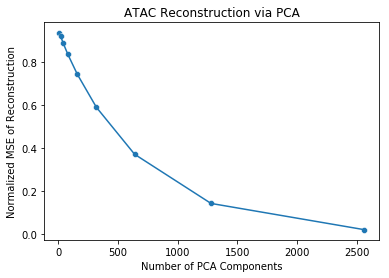

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.scatterplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
sns.lineplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
ax.set(ylabel='Normalized MSE of Reconstruction', title='ATAC Reconstruction via PCA')
plt.savefig('atac_pca_recon.png', dpi=300)

In [78]:
pca_recon_df.to_csv('atac_pca_recon_experiment.csv', index=False)

In [77]:
atac.shape

(6897, 3808)

In [81]:
mses = []
n_vals = [10*(2**k) for k in range(9)]
for n_components in n_vals:
    mses.append(test_pca_reconstruction(rna, n_components))
    
import pandas as pd
pca_recon_df = pd.DataFrame()
pca_recon_df['Normalized MSE'] = mses
pca_recon_df['Number of PCA Components'] = n_vals
pca_recon_df.to_csv('rna_pca_recon_experiment.csv', index=False)

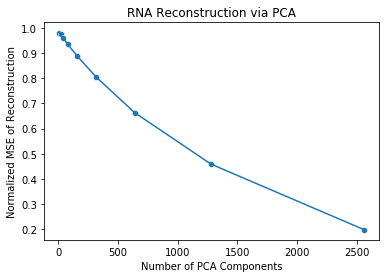

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.scatterplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
sns.lineplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
ax.set(ylabel='Normalized MSE of Reconstruction', title='RNA Reconstruction via PCA')
plt.savefig('rna_pca_recon.png', dpi=300)

In [86]:
rna_df = pd.read_csv('rna_pca_recon_experiment.csv')
atac_df = pd.read_csv('atac_pca_recon_experiment.csv')

In [89]:
merged = pd.DataFrame()
merged['Number of PCA Components'] = rna_df['Number of PCA Components']
merged['RNA'] = rna_df['Normalized MSE']
merged['ATAC'] = atac_df['Normalized MSE']
merged.to_csv('rna_atac_recon.csv', index=False)

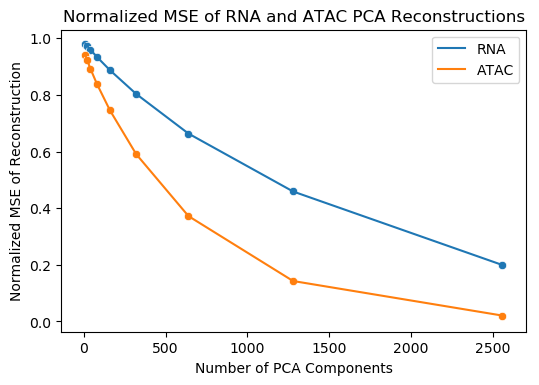

In [103]:
ax = sns.scatterplot(data=merged, x='Number of PCA Components', y='RNA')
sns.scatterplot(data=merged, x='Number of PCA Components', y='ATAC')
sns.lineplot(data=merged, x='Number of PCA Components', y='RNA', label='RNA')
sns.lineplot(data=merged, x='Number of PCA Components', y='ATAC', label='ATAC')
ax.set(ylabel='Normalized MSE of Reconstruction', title='Normalized MSE of RNA and ATAC PCA Reconstructions')
plt.savefig('rna_atac_recon.png', dpi=300)

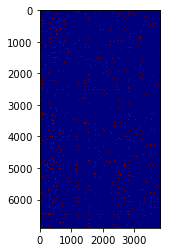

In [14]:
import matplotlib.pyplot as plt

plt.imshow(atac, cmap='jet')

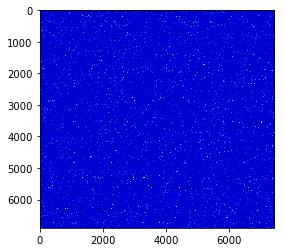

In [15]:
plt.imshow(rna, cmap='jet')

2